In [1]:
import torch
import time
from torch import utils
from torch import nn
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.pyplot import imshow
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

from livelossplot import PlotLosses

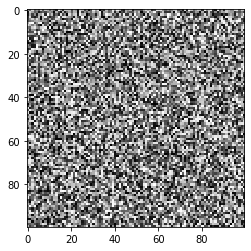

[[0.4980928  0.42876937 0.84859916 ... 0.42700153 0.77196651 0.73566035]
 [0.08060776 0.80534    0.63170986 ... 0.3225292  0.48354065 0.29613579]
 [0.11136162 0.68912746 0.24677228 ... 0.44083148 0.63506299 0.93032375]
 ...
 [0.68663244 0.70815077 0.0315676  ... 0.60326721 0.08373853 0.10566334]
 [0.34042532 0.3663674  0.47037901 ... 0.68211728 0.09008916 0.35485522]
 [0.69632354 0.23406044 0.41238906 ... 0.76925788 0.57797996 0.09247335]]


In [2]:
from PIL import Image
import numpy as np
%matplotlib inline

X = np.random.random((100, 100)) # sample 2D array
plt.imshow(X, cmap="gray")
plt.show()
print(X)

In [5]:
height = 10;
width = 10;

In [6]:
start = (torch.rand(height * width).view( 1, 1, height, width) > 0.5).type(torch.float32)

In [7]:
print(start)

tensor([[[[0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 1., 1., 0., 0., 0., 1., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
          [0., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
          [1., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
          [1., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 1., 0., 0., 1., 1., 0., 1., 0.],
          [0., 0., 0., 1., 1., 0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 0., 1., 0., 1., 1., 1.],
          [0., 1., 1., 0., 0., 1., 0., 1., 1., 1.]]]])


In [8]:
beacon = torch.tensor([[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]])

In [9]:
def generate_pixel(current_image):
    kernel = torch.tensor([[[[1.0, 1.0, 1.0],
                       [1.0, 0.0, 1.0],
                       [1.0, 1.0, 1.0]]]], dtype=torch.float32)
    neighbours = torch.conv2d(current_image, kernel)
    if neighbours == 3.0 or neighbours == 2 and current_image.squeeze(dim=0).squeeze(dim=0)[1][1]:
        return torch.tensor([[[1]]])
    
    return torch.tensor([[[0]]])   

In [10]:
def generate_next(current_image):
    kernel = torch.tensor([[[[1.0, 1.0, 1.0],
                       [1.0, 0.0, 1.0],
                       [1.0, 1.0, 1.0]]]], dtype=torch.float32)
    neighbours = torch.conv2d(current_image, kernel, padding=1)
    next_image_new = (neighbours == 3).type(torch.float32)
    next_image_remain = (neighbours+current_image == 3).type(torch.float32)
    next_image = torch.max(next_image_new, next_image_remain)
    return next_image
  

In [11]:
%matplotlib notebook
def run(frame, n):

    plt.imshow(frame.squeeze(dim=0).squeeze(dim=0), cmap="gray", animated=True)
    for i in range(n):
        time.sleep(0.3)
        frame = generate_next(frame)
        clear_output(wait=True)
        plt.imshow(frame.squeeze(dim=0).squeeze(dim=0), cmap="gray", animated=True)
        plt.show()

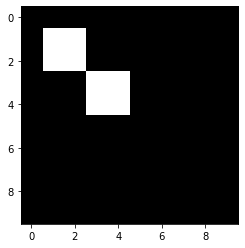

In [12]:
%matplotlib inline
run(beacon, 10)

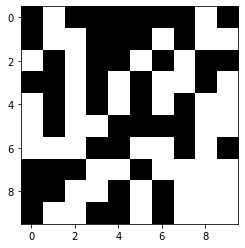

In [13]:
%matplotlib inline
plt.imshow(start.squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()

In [14]:
def generate_dataset_0(train_set_size, validation_set_size, test_set_size):
    width = 3
    height = 3
    X_train = torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    X_validate =  torch.zeros(1, 1, train_set_size).view(train_set_size, 1, 1)
    X_test =  torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    y_train = torch.zeros(1, 1, train_set_size).view(train_set_size, 1, 1)
    y_validate =  torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    y_test = torch.zeros(1, 1, train_set_size).view(train_set_size, 1, 1)
        
    prob = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
    p = 0
              
    for i in range(train_set_size):
        frame = (torch.rand(height * width).view( 1, 1, height, width) > prob[p]).type(torch.float32)
        X_train[i] = frame
        y_train[i] = generate_pixel(frame)
        p=(p+1)%9
    
    X_train = X_train.unsqueeze(dim=1)
    y_train = y_train.unsqueeze(dim=1)
        
              
    for i in range(validation_set_size):
        frame = (torch.rand(height * width).view( 1, 1, height, width) > prob[p]).type(torch.float32)
        X_validate[i] = frame
        y_validate[i] = generate_pixel(frame).unsqueeze(dim=0)
        p=(p+1)%9
        
    X_validate = X_validate.unsqueeze(dim=1)
    y_validate = y_validate.unsqueeze(dim=1)
        
              
    for i in range(test_set_size):
        frame = (torch.rand(height * width).view( 1, 1, height, width) > prob[p]).type(torch.float32)
        X_test[i] = frame
        y_test[i] = generate_pixel(frame).unsqueeze(dim=0)
        p=(p+1)%9
        
    X_test = X_test.unsqueeze(dim=1)
    y_test = y_test.unsqueeze(dim=1)
    
    return (X_train, y_train, X_validate, y_validate, X_test, y_test)
    

In [15]:
def generate_dataset(width, height, train_set_size, validation_set_size, test_set_size):
    
    X_train = torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    X_validate =  torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    X_test =  torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    y_train = torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    y_validate =  torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    y_test = torch.zeros(width, height, train_set_size).view(train_set_size, height, width)
    
    prob = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
    p = 0
              
    for i in range(train_set_size):
        frame = (torch.rand(height * width).view( 1, 1, height, width) > prob[p]).type(torch.float32)
        X_train[i] = frame
        y_train[i] = generate_next(frame)
        p=(p+1)%9
    
    X_train = X_train.unsqueeze(dim=1)
    y_train = y_train.unsqueeze(dim=1)
        
              
    for i in range(validation_set_size):
        frame = (torch.rand(height * width).view( 1, 1, height, width) > prob[p]).type(torch.float32)
        X_validate[i] = frame.unsqueeze(dim=0)
        y_validate[i] = generate_next(frame).unsqueeze(dim=0)
        p=(p+1)%9
        
    X_validate = X_validate.unsqueeze(dim=1)
    y_validate = y_validate.unsqueeze(dim=1)
        
              
    for i in range(test_set_size):
        frame = (torch.rand(height * width).view( 1, 1, height, width) > prob[p]).type(torch.float32)
        X_test[i] = frame.unsqueeze(dim=0)
        y_test[i] = generate_next(frame).unsqueeze(dim=0)
        p=(p+1)%9
        
    X_test = X_test.unsqueeze(dim=1)
    y_test = y_test.unsqueeze(dim=1)
    
    return (X_train, y_train, X_validate, y_validate, X_test, y_test)

In [16]:
X_train, y_train, X_validate, y_validate, X_test, y_test = generate_dataset(10, 10, 1000, 100, 100)

In [17]:
X_train[0].size()

torch.Size([1, 10, 10])

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=1)
        self.fc1 = nn.Linear(10*10, 10*10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10*10)
        x = F.relu(self.fc1(x))
        #x = (x+1)**2

        return x

In [47]:
def conv_train_step(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.reshape([-1, 1, 10, 10]).size())
        #print(target.size())
        loss = F.mse_loss(output.reshape([-1, 1, 10, 10]), target)
        loss.backward()
        optimizer.step()
        
        train_loss += F.mse_loss(output.reshape([-1, 1, 10, 10]), target, reduction="sum").item() # sum up batch loss
    
    avg_loss = train_loss / len(train_loader.dataset)
    
    return avg_loss


def conv_test_step(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output.reshape([-1, 1, 10, 10]), target, reduction="sum").item() # sum up batch loss
            #pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            #test_correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)

    
    return test_loss
    


In [51]:
device = torch.device("cpu")
model = Net()    
print(model.conv1.weight.data)
train_loader  = DataLoader(TensorDataset(X_train,y_train),
                        batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test),
                        batch_size=32, shuffle=False)  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

liveloss = PlotLosses()

tensor([[[[ 0.3302,  0.2397,  0.0374],
          [ 0.0542, -0.0266, -0.0133],
          [-0.2989, -0.3222,  0.1476]]]])


In [52]:
def conv_train_model(epoch):
    
    for epoch in range(epoch):
        avg_loss = conv_train_step(model, device, train_loader, optimizer, epoch)
        avg_loss_val = conv_test_step(model, device, test_loader)
        
        liveloss.update({
            'val loss': avg_loss_val,
            'loss': avg_loss,
        })
    
        liveloss.draw()

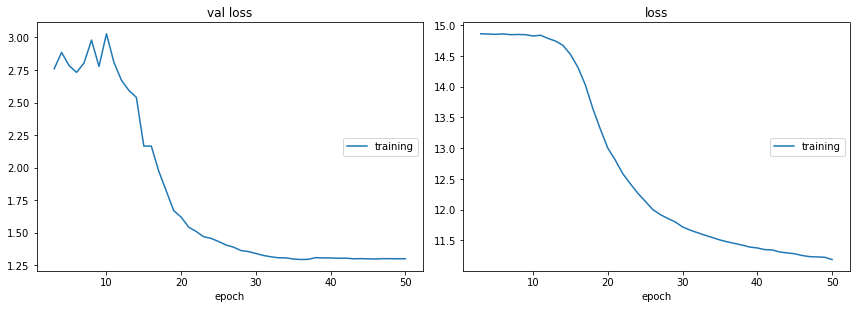

val loss:
training   (min:    1.294, max:    3.135, cur:    1.300)

loss:
training   (min:   11.187, max:   15.044, cur:   11.187)


In [53]:
conv_train_model(50)

In [54]:
kernels = model.conv1.weight.detach().cpu().numpy()

In [55]:
kernels

array([[[[0.7068606 , 0.8338059 , 0.5618657 ],
         [0.51896644, 0.6283788 , 0.48269475],
         [0.42468947, 0.351707  , 0.52000695]]]], dtype=float32)

In [56]:
res = (model(X_validate[3].unsqueeze(dim=0)).detach().view([10, 10])>0.25).type(torch.float32)
res

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

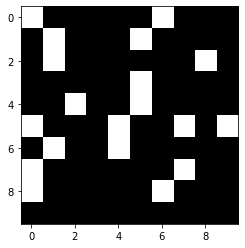

In [57]:
%matplotlib inline
plt.imshow(X_validate[3].squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()

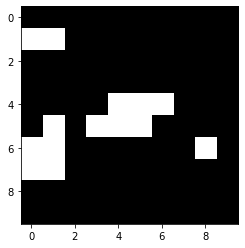

In [58]:
%matplotlib inline
plt.imshow(y_validate[3].squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()

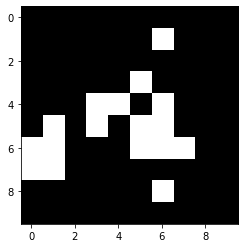

In [59]:
%matplotlib inline
plt.imshow(res, cmap="gray")
plt.show()

In [ ]:
prop = generate_next(start)
%matplotlib inline
plt.imshow(prop.squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()